In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a regression problem.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis.
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization. -> 🎯 **Focus on this task** data preparation and feature selection (feature extraction part of sliding window method).
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.


# Imports + Settings

In [3]:
# third-party libraries
import pandas as pd
import numpy as np
import os
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from scipy.stats import multivariate_normal, zscore
from scipy.stats._mstats_basic import winsorize

In [4]:
# source code
from src.data_loading import load_data, load_config
from src.rolling_window_creator import RollingWindowDatasetCreator, calculate_RUL
from src.data_cleaning import identify_missing_values, identify_single_unique_features, format_dtype

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')

In [6]:
np.random.seed(42)

# Paths

In [7]:
os.chdir("../") # set working directory to root of project
#os.getcwd() # check current working directory

In [8]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load config + Data

In [9]:
config = load_config(PATH_TO_CONFIG) # config is dict

In [10]:
%%time
train_data, test_data, test_RUL_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=1)

2024-05-30 12:14:17 [src.data_loading:43] [INFO] >>>> Loading data set 1...
2024-05-30 12:14:18 [src.data_loading:72] [INFO] >>>> Loaded raw data for dataset 1.
2024-05-30 12:14:18 [src.data_loading:73] [INFO] >>>> Train Data: (20631, 26)
2024-05-30 12:14:18 [src.data_loading:74] [INFO] >>>> Test Data: (13096, 26)
2024-05-30 12:14:18 [src.data_loading:75] [INFO] >>>> Test RUL Data: (100, 1)
CPU times: total: 141 ms
Wall time: 329 ms


In [11]:
# count unit numbers in test set
print(f"Number of unique unit numbers in test set: {test_data['UnitNumber'].nunique()}")
# count min number of cycles in test set for each unit number --> window size must be in the range of these values, for example a window size of 10 would be too large if there is a unit number with only 10 cycles
print("Min number of cycles in test set for a unit number: ", test_data.groupby("UnitNumber")["Cycle"].count().min())

Number of unique unit numbers in test set: 100
Min number of cycles in test set for a unit number:  31


# Data Preprocessing
1. Clean Data
2. Windowing
3. (Post-Windowing Preprocessing) not necessary
4. (Dimensionality Reduction) [TBD]
5. (Feature Selection) [TBD]

## 1. Clean Data
Possible Steps, which can be applied to the data. The steps are not mandatory and can be adjusted according to the data and the problem at hand. The ones marked with ✅ are implemented in our case and modulated in the ```src.data_cleaning``` module:
* format/encode column types - only necessary if categorical columns are present ✅
* handle missing values ✅
* handle single unique values ✅
* handle duplicates ✅
* handle outliers ✅
* handle features without correlation with target ✅
* Data Scaling: Normalize/Standardize ✅
* Optional: Detect and Remove Multicollinearity ?
    * Identify highly correlated features using correlation matrices or Variance Inflation Factor (VIF) and consider removing or combining them to reduce redundancy
* Optional: feature engineering ?
    * Polynomial Features: Generating polynomial features may capture non-linear relationships between the features and the target
    * Binning: Group/discretize continous feature values with rarely occurring realizations into bins to handle non-linear relationships or to reduce the impact of outliers and noise



### Format Column Types

In [12]:
formatted_df = format_dtype(train_data)

2024-05-30 12:14:18 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []


### Handle Missing Values

In [13]:
missing_features = identify_missing_values(train_data, threshold=0.1)
missing_features

2024-05-30 12:14:18 [src.data_cleaning:30] [DEBUG] >>>> Found 0 features with missing values above the threshold of 0.1.


[]

In [14]:
# drop features with missing values, where the percentage of missing values is above the given threshold, other than that the missing values are filled with the median
train_data.drop(missing_features, axis=1, inplace=True)
test_data.drop(missing_features, axis=1, inplace=True)

In [15]:
# impute the remaining missing values using interpolation (splines)
train_data.interpolate(method='spline', order=3, inplace=True)
test_data.interpolate(method='spline', order=3, inplace=True)

### Handle Single Unique Values

In [16]:
single_unique_features = identify_single_unique_features(train_data)
single_unique_features

2024-05-30 12:14:18 [src.data_cleaning:54] [DEBUG] >>>> Found 7 features with only a single unique value: ['Operation Setting 3', 'Sensor Measure 1', 'Sensor Measure 5', 'Sensor Measure 10', 'Sensor Measure 16', 'Sensor Measure 18', 'Sensor Measure 19']


['Operation Setting 3',
 'Sensor Measure 1',
 'Sensor Measure 5',
 'Sensor Measure 10',
 'Sensor Measure 16',
 'Sensor Measure 18',
 'Sensor Measure 19']

In [17]:
# drop features with single unique values
train_data.drop(single_unique_features, axis=1, inplace=True)
test_data.drop(single_unique_features, axis=1, inplace=True)

### Handle duplicates

In [18]:
# get number of duplicates
print(f"Number of duplicates in train data: {train_data.duplicated().sum()}")
print(f"Number of duplicates in test data: {test_data.duplicated().sum()}")
# drop duplicates
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

Number of duplicates in train data: 0
Number of duplicates in test data: 0


### Handle Outliers
Possible Methods to investigate and possibly test. The ones marked with ✅ are implemented in our case and modulated in the ```src.outlier_detection``` module:
* Z-Score ✅
* IQR ✅
* Winsorization ✅
* Isolation Forest ❌
* Local Outlier Factor (LOF) ✅
* Elliptic Envelope ✅

#### Z-Score
**Use Case**: Normally distributed data
**Assumption**: Assumes that the data follows a normal distribution. It identifies outliers based on how many standard deviations away from the mean a data point is.
* --> Suitable for normally distributed data. Could be useful since the data might be normally distributed. As can also be seen in some of the histograms below.
* ✅ **Use Z-Score for outlier detection.**



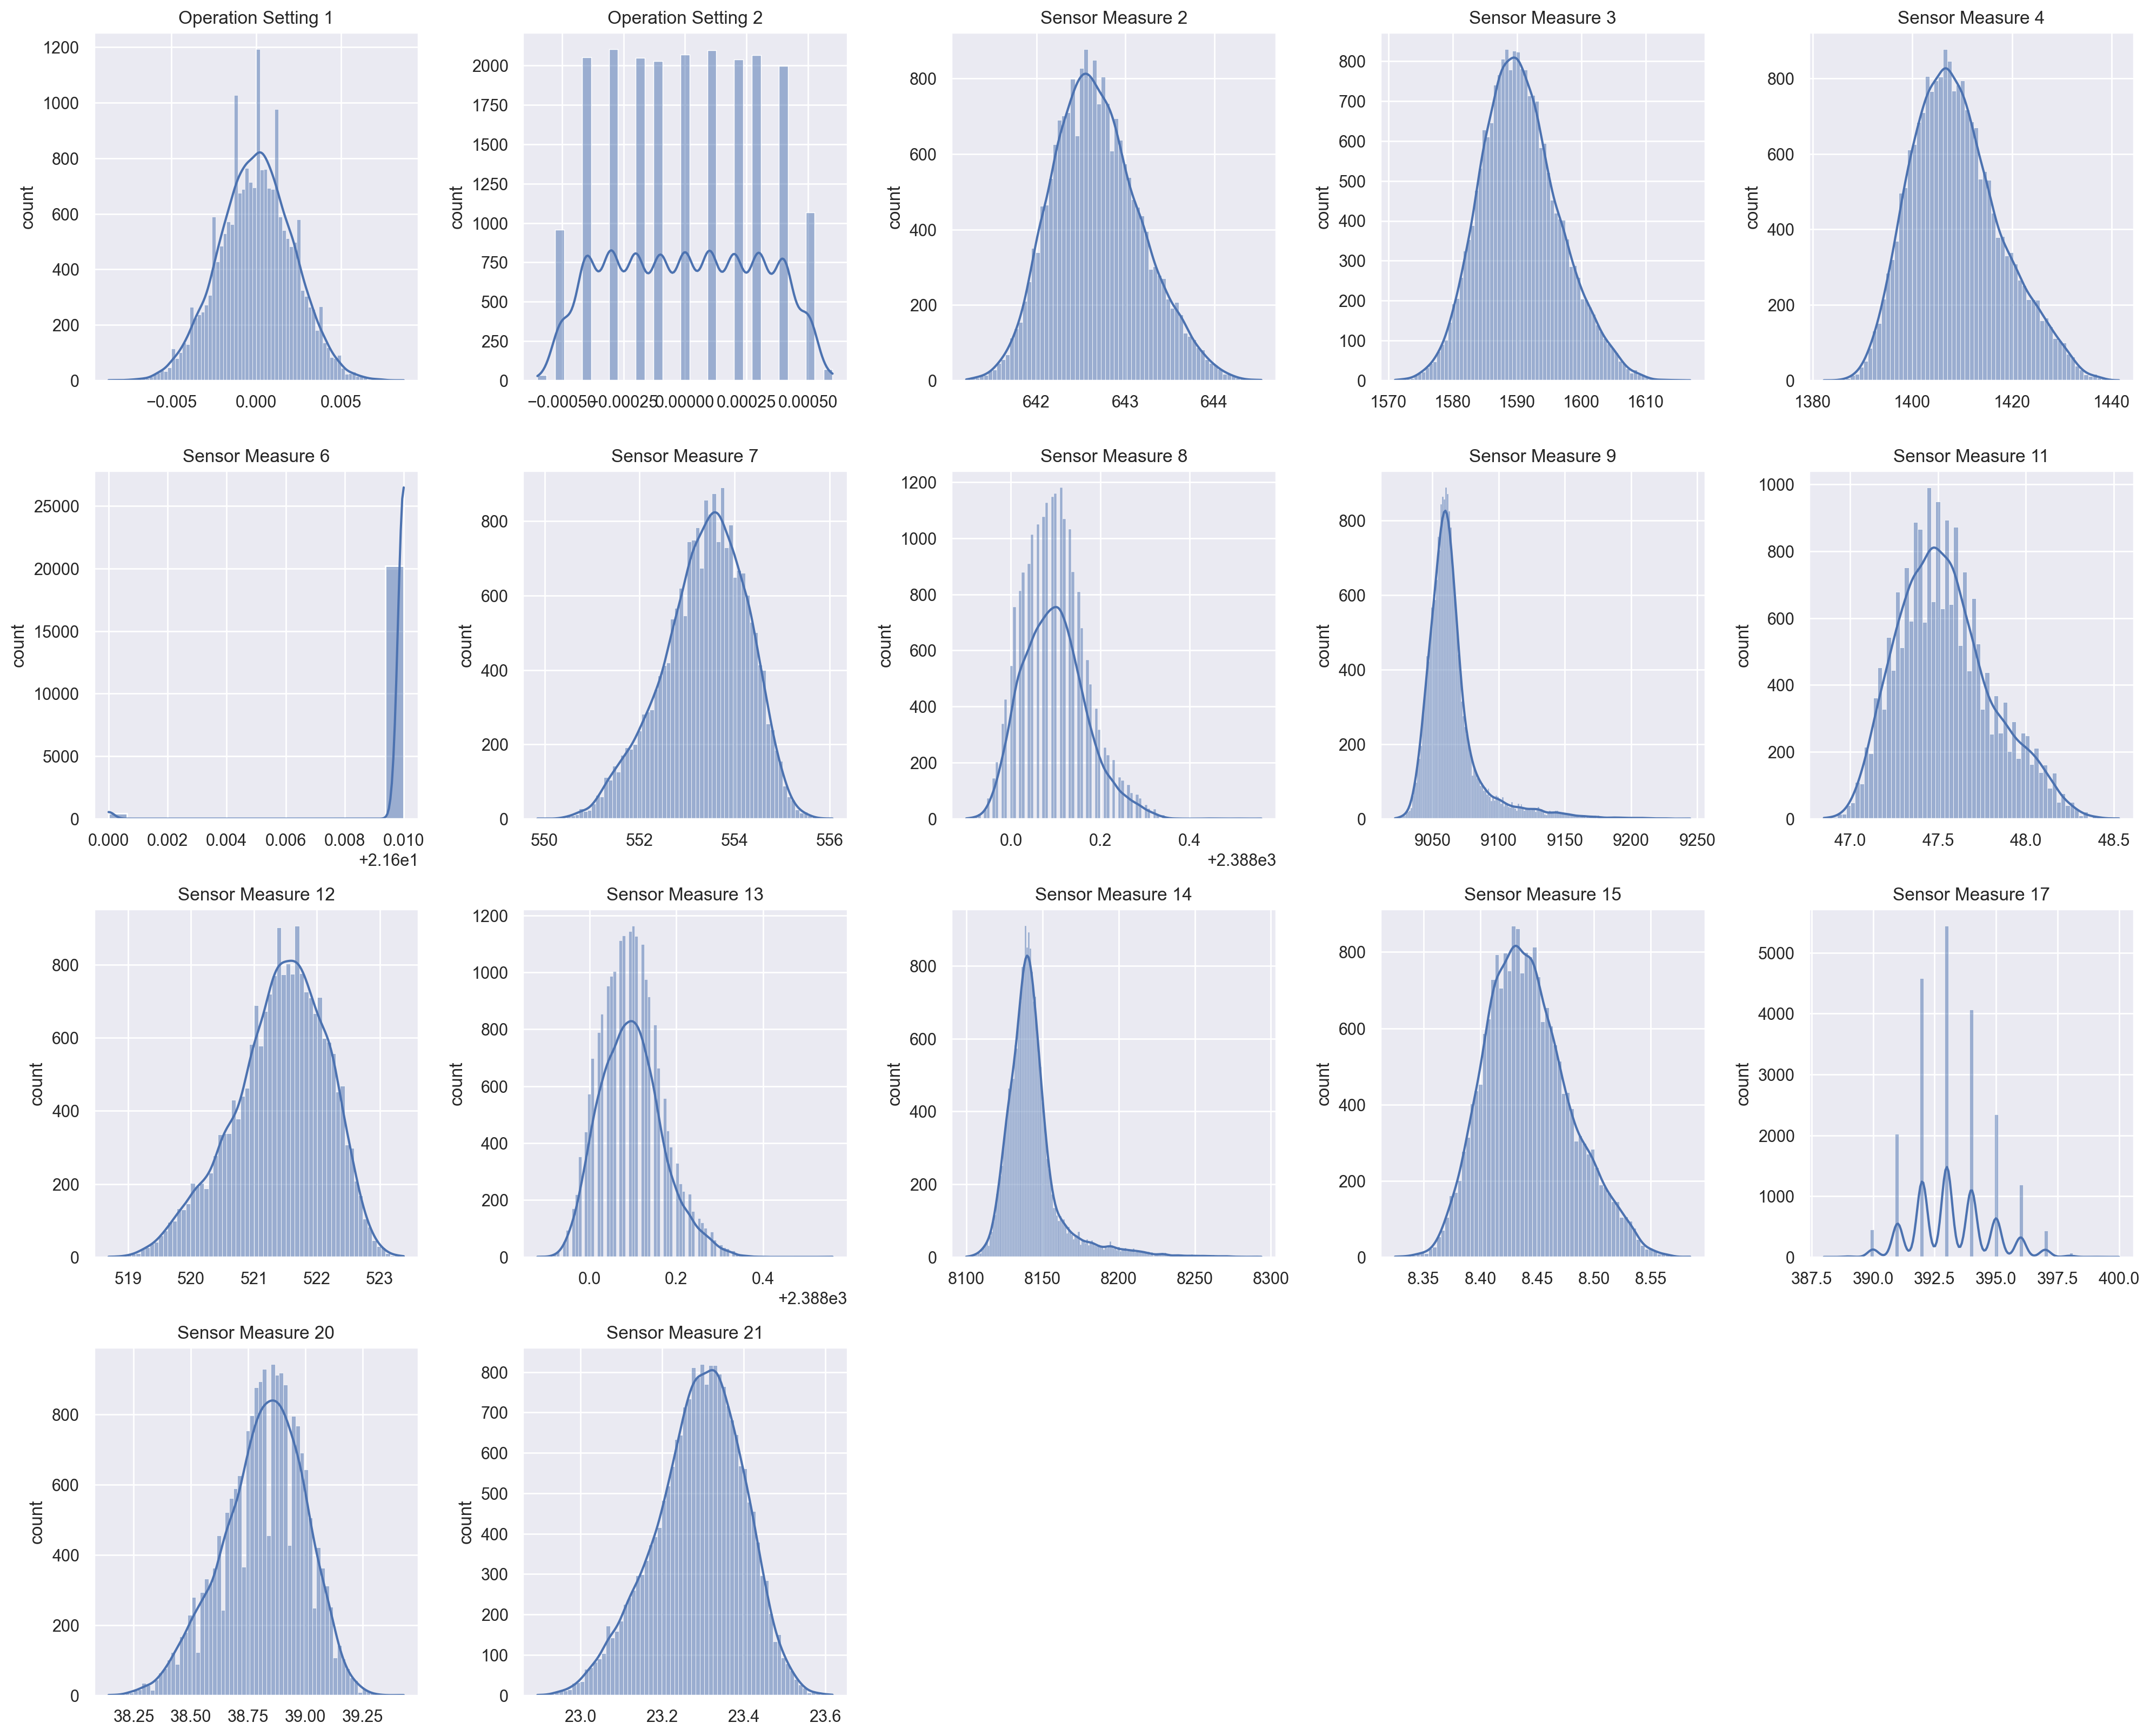

In [19]:
# visual inspection
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_data.drop(['UnitNumber', 'Cycle'], axis = 1).columns):
    plt.subplot(5, 5, i+1)
    sns.histplot(train_data[col], kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('count')
plt.tight_layout()
plt.show()

Findings:
Set 1:
* ```Sensor Measure 6``` is highly skewed -> **investigate further**(drop feature), indicating non-normal distribution
* ```Operation Setting 2``` and ```Sensor Measure 17``` have multiple peaks and seem to only have a few unique numeric values -> **investigate further** (group into buckets, drop, etc.), indicating non-normal distribution
* All other features exhibit approximately normal distributions, indicated by a single peak with bell-shaped curves.

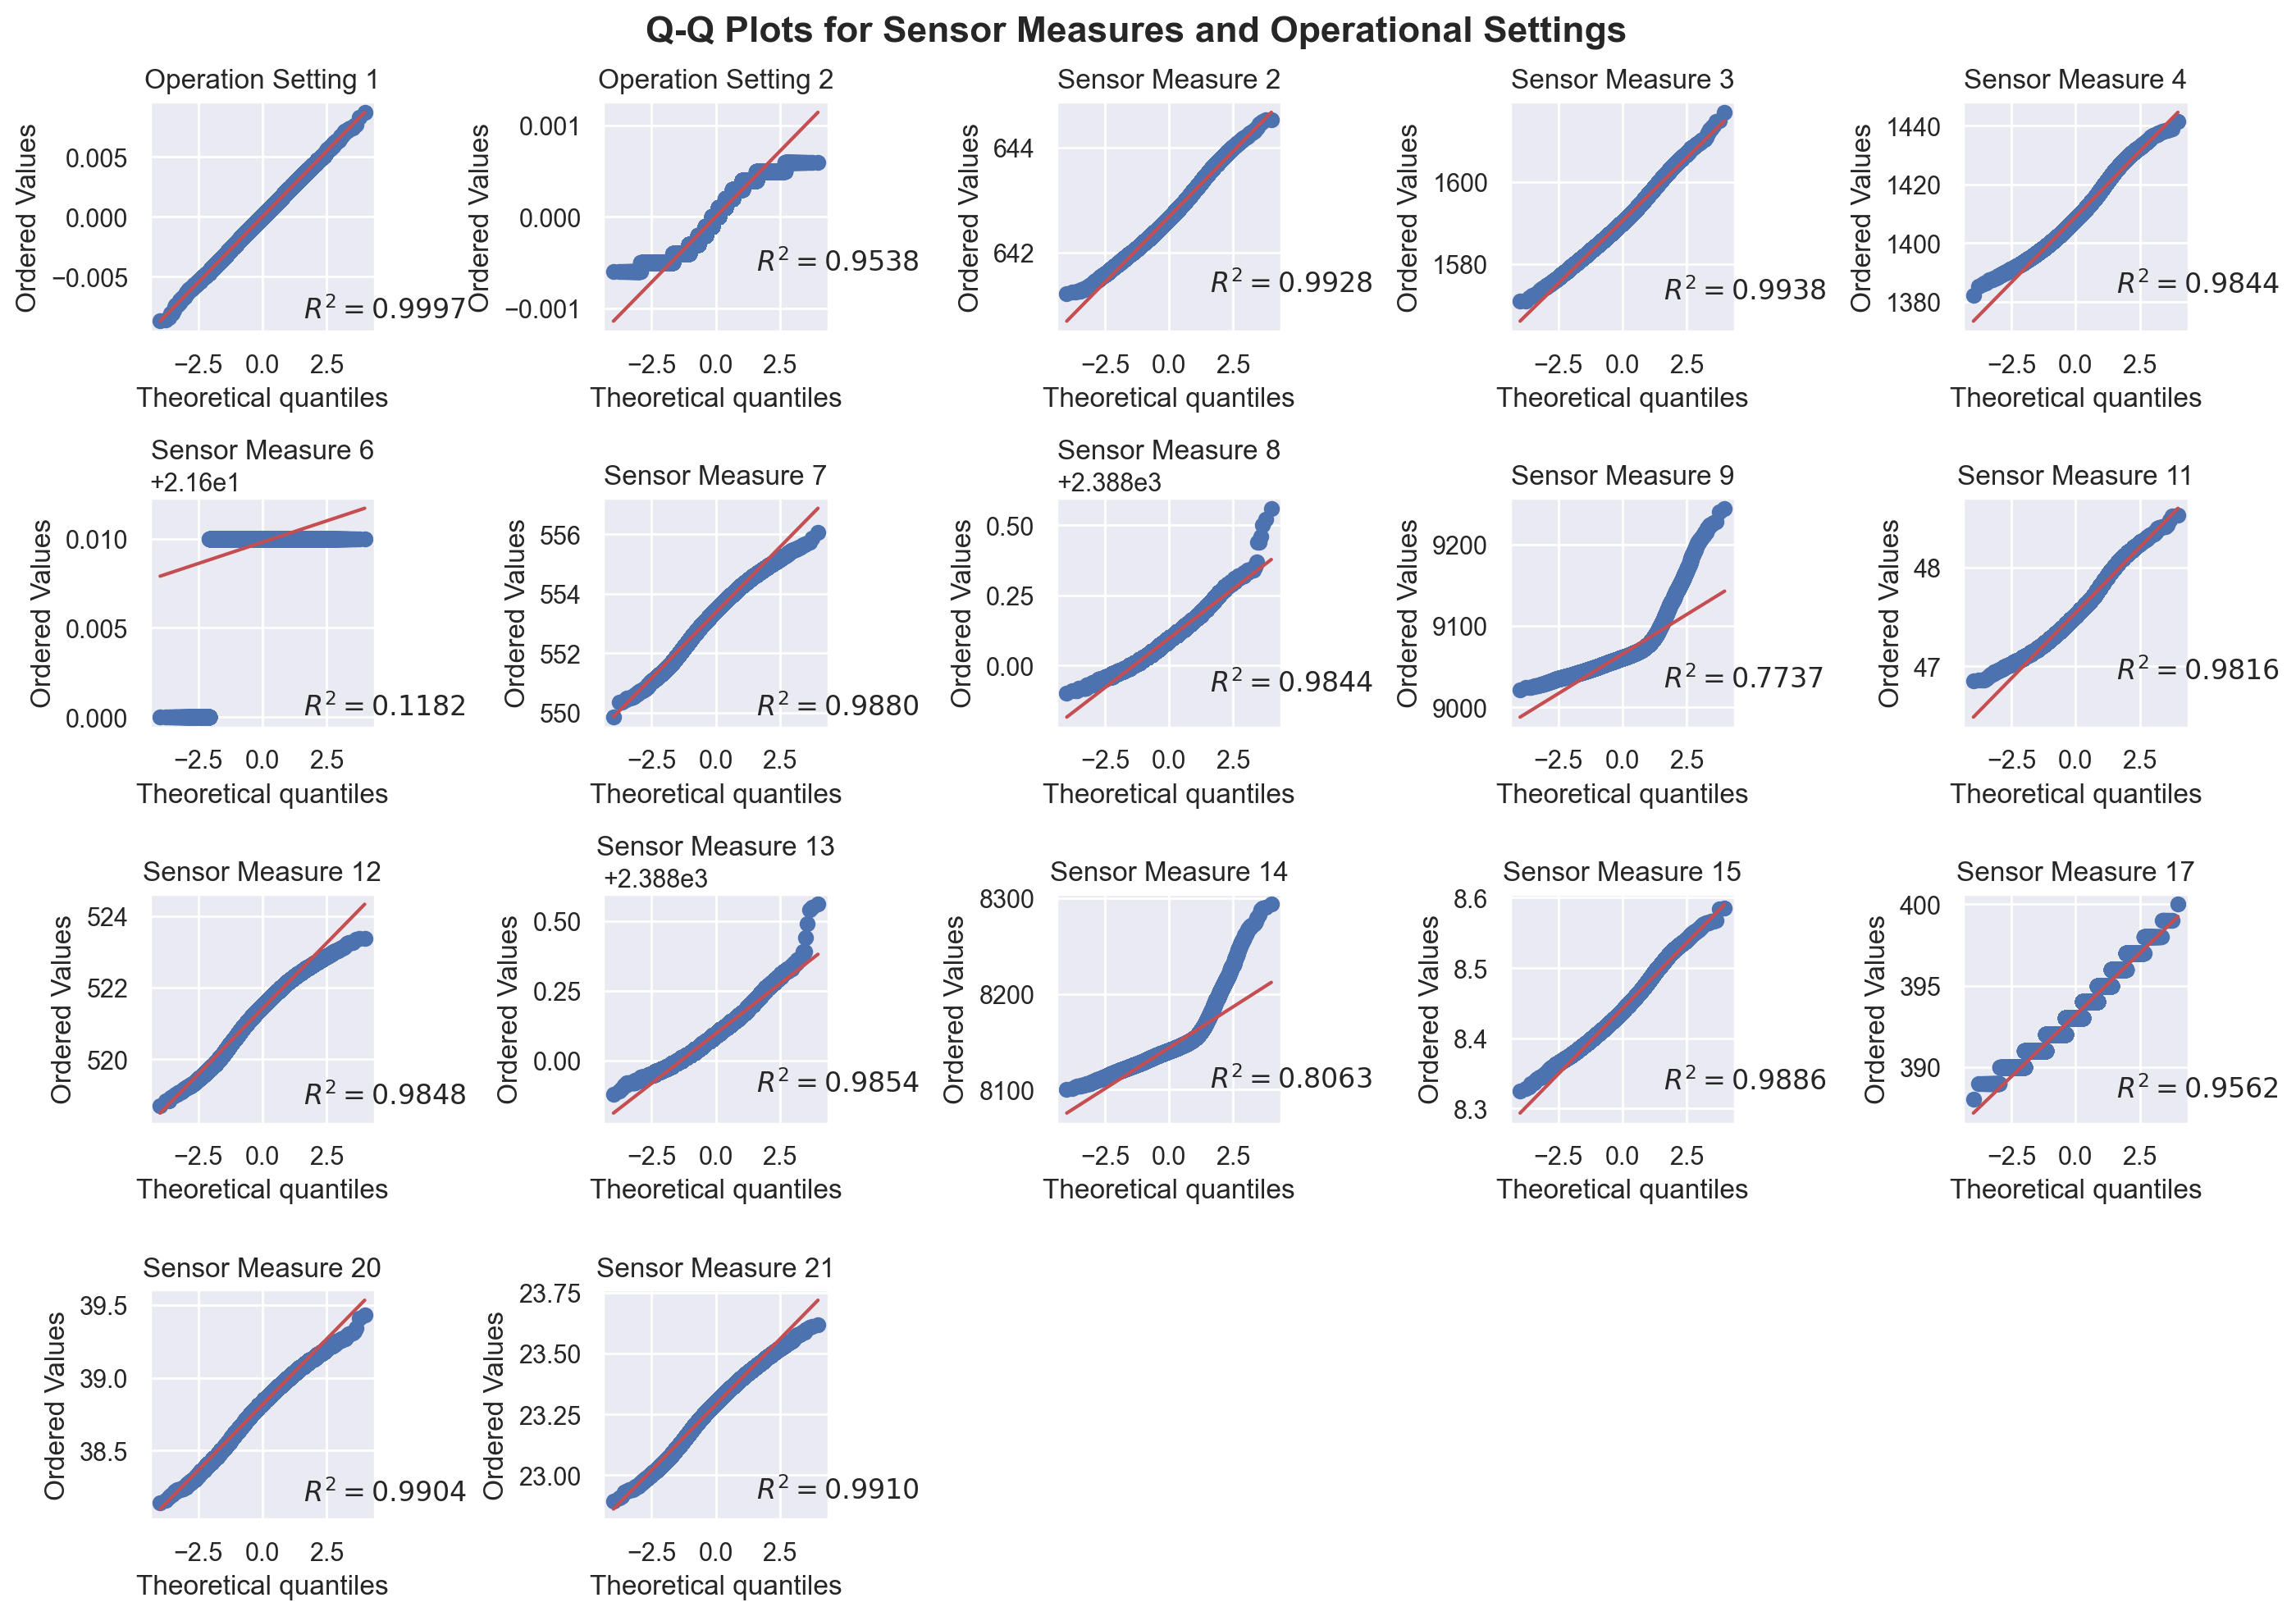

In [20]:
# Q-Q Plot for normally distributed data
plt.figure(figsize=(14, 12))
for i, col in enumerate(train_data.drop(['UnitNumber', 'Cycle'], axis = 1).columns):
    plt.subplot(5, 5, i+1)
    stats.probplot(train_data[col], dist="norm", plot=plt, fit=True, rvalue=True)
    plt.title(col)
plt.suptitle('Q-Q Plots for Sensor Measures and Operational Settings',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Findings:
* ```Sensor Measure 6```: Gradually deviates from the straight line, indicating non-normal distribution as already observed in the previous histogram.
* The others show a good fit to the straight line, with some deviations at the tails, which is expected for real-world data.
* ```Sensor Measure 14```, ```Sensor Measure 9```, show bothe the same trend, a slight deviation from the straight line, indicating a slight deviation from normality.

In [21]:
from src.outlier_detection import remove_outliers_zscore

In [22]:
train_data_cleaned = remove_outliers_zscore(train_data.drop(['UnitNumber', 'Cycle'], axis=1), soft_drop=True, threshold_sd=0.3)

2024-05-30 12:14:32 [src.outlier_detection:35] [DEBUG] >>>> Found 1 samples to be softly dropped.
2024-05-30 12:14:32 [src.outlier_detection:42] [DEBUG] >>>> Original DataFrame shape: (20631, 17), Resulting DataFrame shape: (20630, 17)


#### IQR
**Use Case**: Non-normally distributed data
**Assumption**: Suitable for data that may not follow a normal distribution. It defines outliers based on the spread of the middle 50% of the data, rather than assuming a specific distribution.

* --> Use IQR for non-normally distributed data. Could be useful since depending on the datset the data might not be normally distributed. As can also be seen in some of the histograms above.
* ✅ **Use IQR for outlier detection.**



In [23]:
from src.outlier_detection import remove_outliers_iqr

In [24]:
train_data_cleaned = remove_outliers_iqr(train_data.drop(['UnitNumber', 'Cycle'], axis=1), soft_drop=True, threshold_sd=0.3)

2024-05-30 12:14:32 [src.outlier_detection:70] [DEBUG] >>>> Found 29 samples to be softly dropped.
2024-05-30 12:14:32 [src.outlier_detection:77] [DEBUG] >>>> Original DataFrame shape: (20631, 17), Resulting DataFrame shape: (20602, 17)


#### Winsorization
**Use Case**: Non-normally distributed data, when you need to reduce the influence of outliers without removing data points.
**Assumption**: It doesn't assume any specific distribution but instead modifies extreme values to be less influential while preserving the data's overall distribution.

* --> Could be useful since it doesn't assume a specific distribution. Also it does not remove data points, which could be beneficial in some cases.
* ✅ **Use Winsorization for outlier detection.**

In [25]:
from src.outlier_detection import remove_outliers_winsorize

In [26]:
train_data_cleaned = remove_outliers_winsorize(train_data.drop(['UnitNumber', 'Cycle'], axis=1), contamination=0.05)

2024-05-30 12:14:33 [src.outlier_detection:98] [DEBUG] >>>> Found 1031 outliers to be replaced (winsorized).
2024-05-30 12:14:33 [src.outlier_detection:100] [DEBUG] >>>> Original DataFrame shape: (20631, 17), Resulting DataFrame shape: (20631, 17)


#### Isolation Forest
**Use Case**: High-dimensional data
**Assumption**: Effective for high-dimensional data where traditional distance-based methods might struggle. It works by isolating outliers in a way that separates them from the rest of the data using a tree-based approach.

* --> High-dimensional data refers to data sets for which the number of variables or dimensions $p$ is much larger than the number of observations $n$, typically $p >> n$. Source: Giraud, C. (2015). *Introduction to High-Dimensional Statistics*. CRC Press.
* ❌ **Not** our case (Shape of X_train: (20131, 170))

#### Local Outlier Factor (LOF)
**Use Case**: Effective for datasets with varying densities.
**Assumption**: LOF is useful for datasets where the density of points varies across the dataset. It calculates the local density around each data point and identifies outliers as points with significantly lower densities compared to their neighbors.

* --> LOF well-suited for our dataset, which exhibits heterogeneous density distributions (see plots).
* ✅ **Use LOF for outlier detection.**

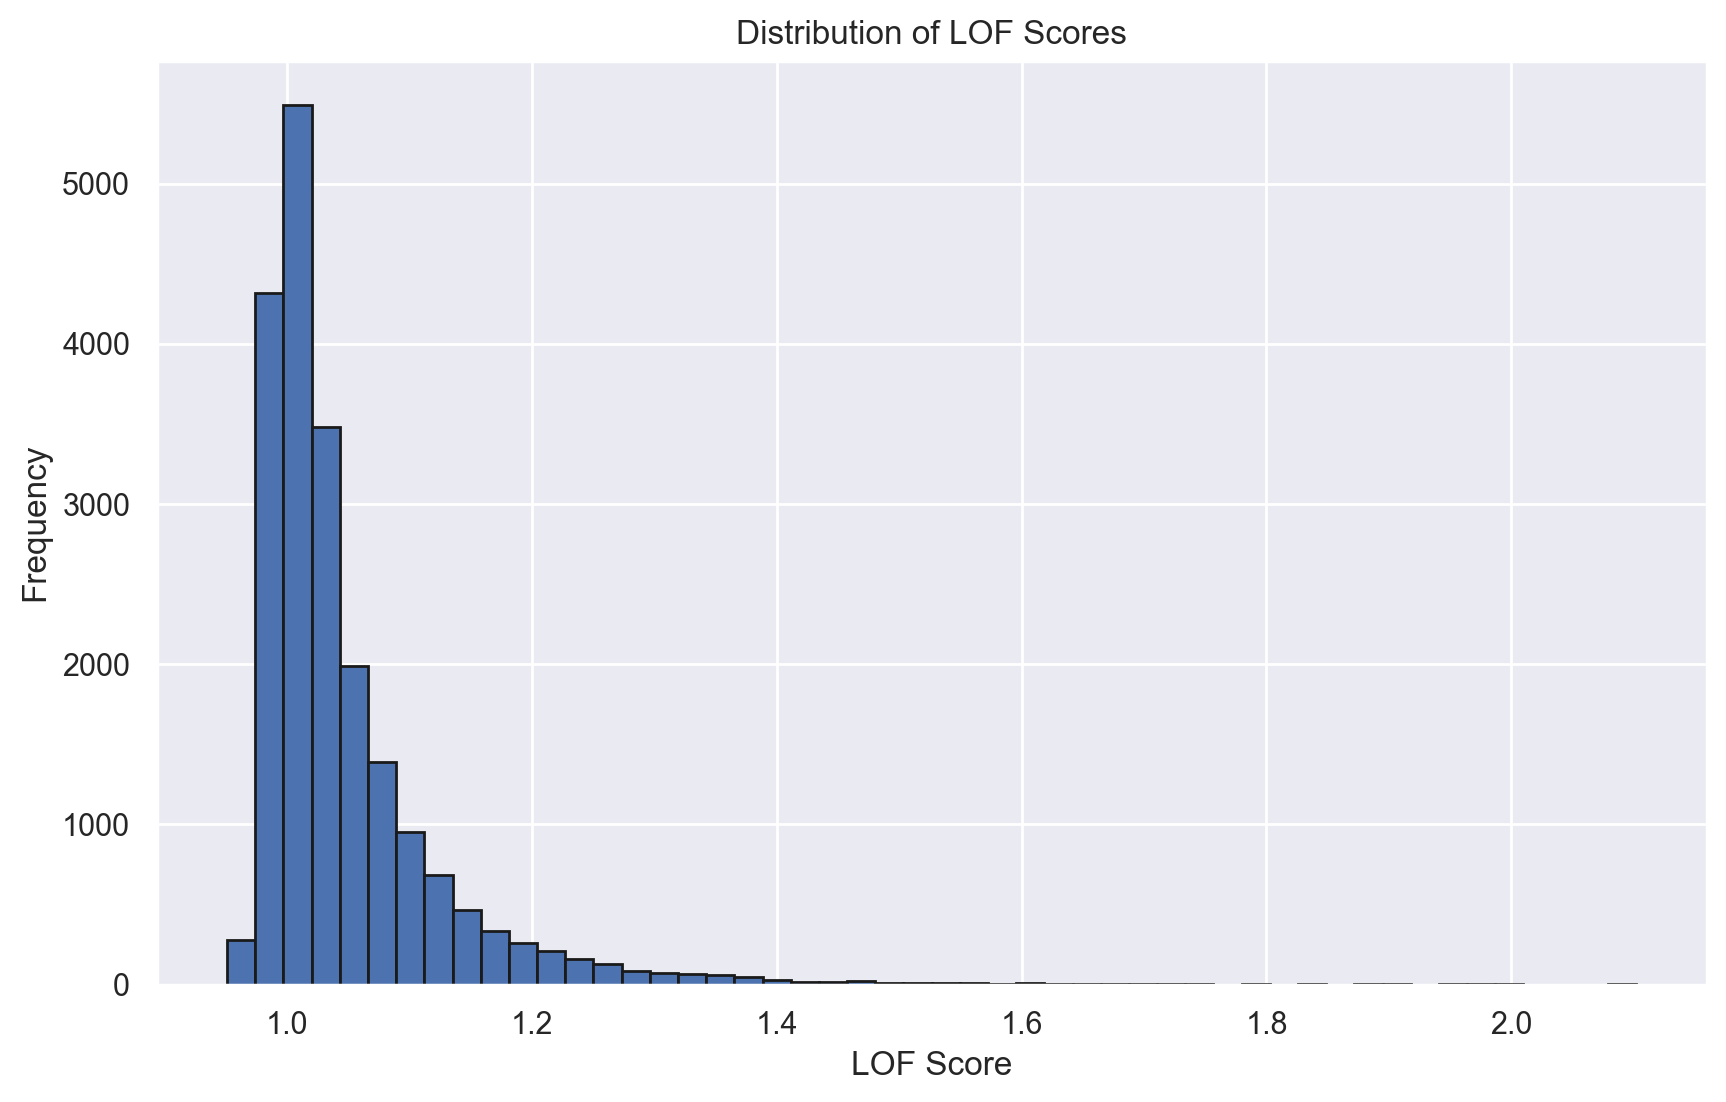

In [27]:
# fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed
lof.fit(train_data.drop(['UnitNumber', 'Cycle'], axis=1))

# calc LOF scores
lof_scores = -lof.negative_outlier_factor_

# plot
plt.figure(figsize=(10, 6))
plt.hist(lof_scores, bins=50, edgecolor='k')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.grid(True)
plt.show()

Findings:
* Presence of scores below 1 indicates regions of exceptionally high data density. --> No outliers in these regions.
* Peak around 1.0 indicates regions of average data density, clustered around a normal density level.
* Gradual decrease in frequency suggests lower density regions.
* Sharp drop at 1.3 may represent areas of lower data density, where outliers may start to emerge.

In [28]:
from src.outlier_detection import remove_outliers_with_lof

In [29]:
train_data_cleaned = remove_outliers_with_lof(train_data, contamination=0.05)

2024-05-30 12:14:38 [src.outlier_detection:122] [DEBUG] >>>> Found 1032 outliers to be dropped.
2024-05-30 12:14:38 [src.outlier_detection:123] [DEBUG] >>>> Original DataFrame shape: (20631, 19), Resulting DataFrame shape: (19599, 19)


#### Elliptic Envelope
**Use Case**: Assumes the data is normally distributed and identifies points that are far from the center. Suitable for multivariate normally distributed data.
**Assumption**: Assumes the data is multivariate normally distributed and aims to identify outliers by fitting an ellipse around the central data points. Points outside this ellipse are considered outliers.

* --> The data is not perfectly multivariate normal, but the method can still be used. See below in the plot.
* ✅ **Use Elliptic Envelope for outlier detection.*



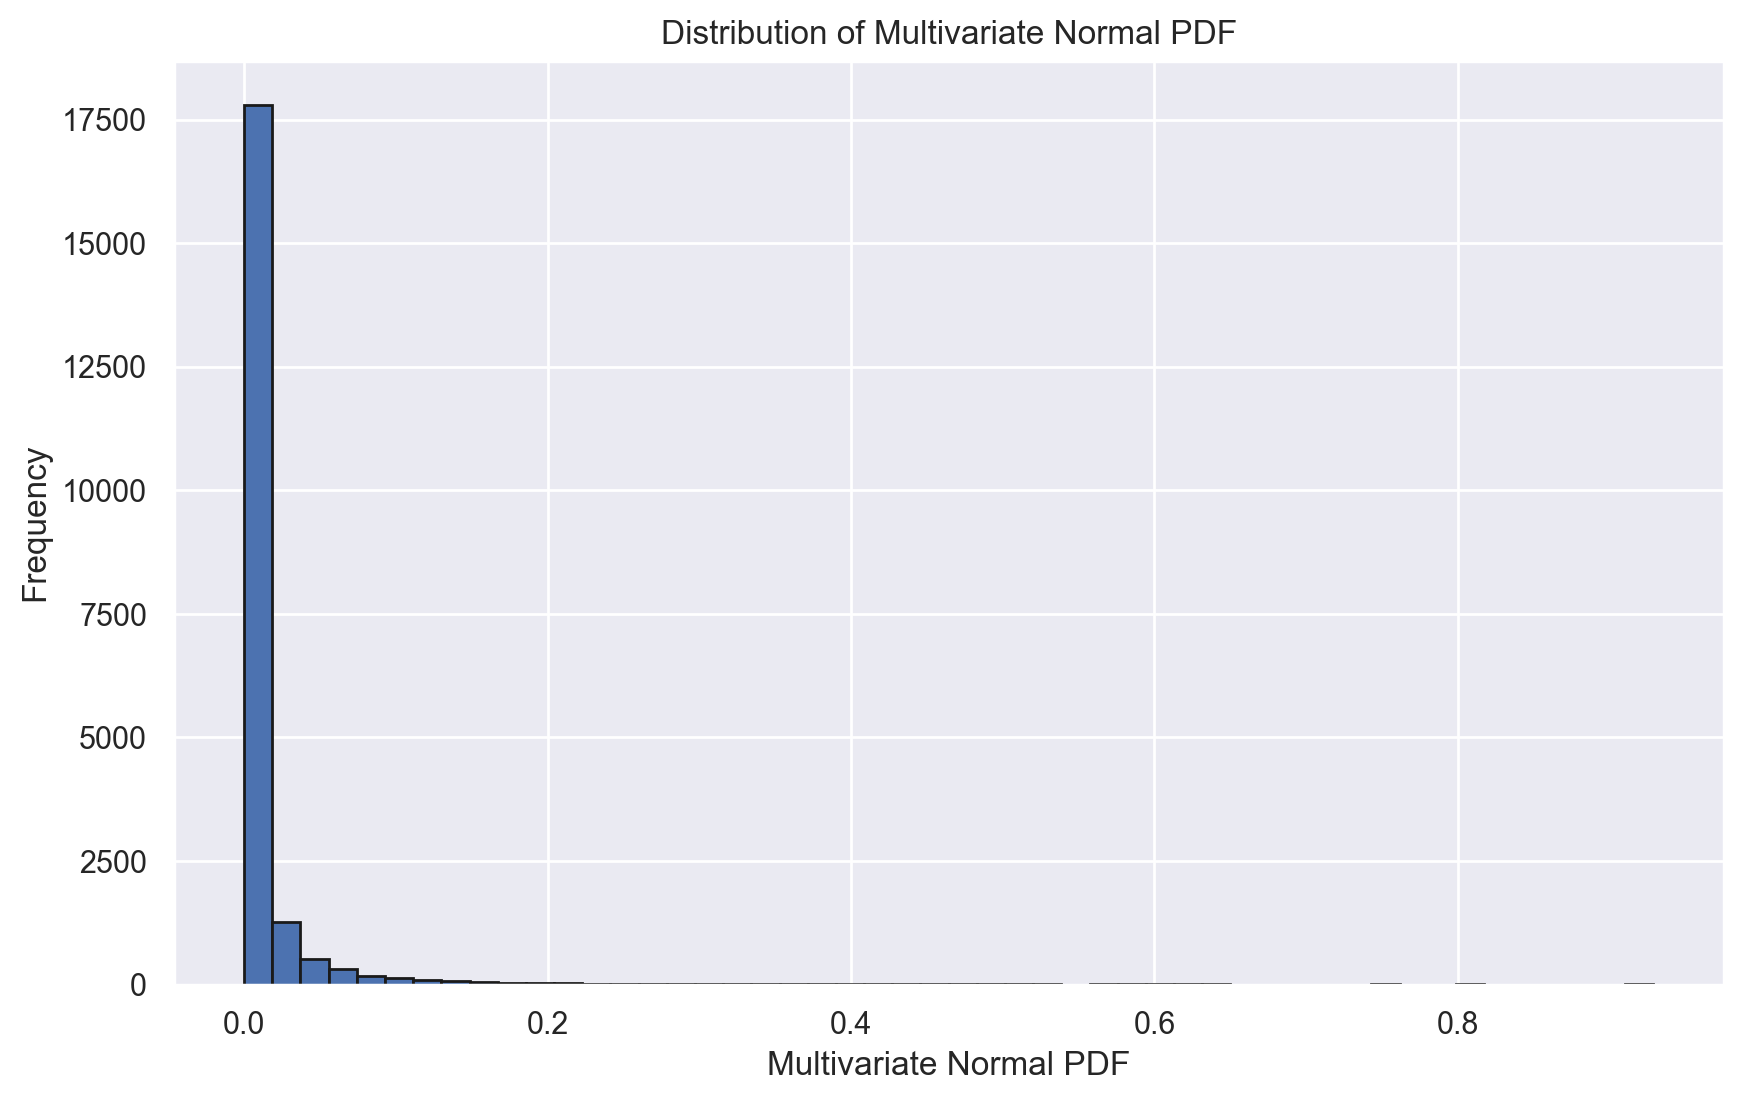

In [30]:
# check for multivariate normality
# fit a multivariate normal distribution to the data
mu = train_data.mean(axis=0)
sigma = train_data.cov()
mvn = multivariate_normal(mean=mu, cov=sigma, allow_singular=True)
# calculate the probability density function for each data point
train_pdf = train_data.copy()
train_pdf['mvn'] = mvn.pdf(train_data)
# plot
plt.figure(figsize=(10, 6))
plt.hist(train_pdf['mvn'], bins=50, edgecolor='k')
plt.xlabel('Multivariate Normal PDF')
plt.ylabel('Frequency')
plt.title('Distribution of Multivariate Normal PDF')
plt.grid(True)
plt.show()

Findings:
* Majority of data points: Most have multivariate normal PDF value close to 0. Considered typical or normal.
* Sparse spread: Some data points spread up to 1.0. Possibly outliers or less typical observations.
--> Majority close to center, typical. Some deviate, potentially outliers. The data is not perfectly multivariate normal, but the method can still be used.

### --> Summary of Outlier Detection

In [31]:
from src.outlier_detection import remove_outliers

In [32]:
# remove outliers using the specified method
train_data_cleaned = remove_outliers(train_data, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], contamination=0.05, threshold_sd=0.8, soft_drop=False)

2024-05-30 12:14:39 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: winsorize ...
2024-05-30 12:14:39 [src.outlier_detection:98] [DEBUG] >>>> Found 1031 outliers to be replaced (winsorized).
2024-05-30 12:14:39 [src.outlier_detection:100] [DEBUG] >>>> Original DataFrame shape: (20631, 19), Resulting DataFrame shape: (20631, 19)


### Handle Correlated Features

In [33]:
from src.data_cleaning import get_uncorrelated_features

In [34]:
train_with_target = calculate_RUL(train_data, time_column='Cycle', group_column='UnitNumber')
uncorrelated_features = get_uncorrelated_features(train_with_target.drop(['UnitNumber', 'Cycle'], axis=1), threshold=0.3, target='RUL')
uncorrelated_features

2024-05-30 12:14:39 [src.data_cleaning:112] [DEBUG] >>>> Found 3 uncorrelated features with a correlation threshold of 0.3: ['Operation Setting 1', 'Operation Setting 2', 'Sensor Measure 6']


['Operation Setting 1', 'Operation Setting 2', 'Sensor Measure 6']

## --> Summary of data cleaning in one function

In [35]:
from src.data_cleaning import clean_data

In [36]:
# clean data (with outlier removal, where no samples are dropped but the outliers are replaced, method='winsorize')
# TODO: outsource settings to config file
cleaned_train, cleaned_test = clean_data(train_data, test_data, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3, contamination=0.05)

2024-05-30 12:14:39 [src.data_cleaning:142] [INFO] >>>> Cleaning train and test data...
2024-05-30 12:14:39 [src.data_cleaning:145] [INFO] >>>> Formatting column types...
2024-05-30 12:14:39 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-30 12:14:39 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-30 12:14:39 [src.data_cleaning:150] [INFO] >>>> Filter and drop features based on missing values, single unique values, and target correlation...
2024-05-30 12:14:39 [src.data_cleaning:30] [DEBUG] >>>> Found 0 features with missing values above the threshold of 0.1.
2024-05-30 12:14:39 [src.data_cleaning:54] [DEBUG] >>>> Found 0 features with only a single unique value: []
2024-05-30 12:14:39 [src.data_cleaning:112] [DEBUG] >>>> Found 4 uncorrelated features with a correlation threshold of 0.3: ['UnitNumber', 'Operation Setting 1', 'Operation Setting 2', 'Sensor Measure 6']
2024-05-30 12:14:39 [src.data_cleaning:161] [INFO] >>>> Dropping

In [37]:
# clean data (without outlier removal/replacement)
cleaned_train, cleaned_test = clean_data(train_data, test_data, method=None, ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3)

2024-05-30 12:14:39 [src.data_cleaning:142] [INFO] >>>> Cleaning train and test data...
2024-05-30 12:14:39 [src.data_cleaning:145] [INFO] >>>> Formatting column types...
2024-05-30 12:14:39 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-30 12:14:39 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-30 12:14:39 [src.data_cleaning:150] [INFO] >>>> Filter and drop features based on missing values, single unique values, and target correlation...
2024-05-30 12:14:39 [src.data_cleaning:30] [DEBUG] >>>> Found 0 features with missing values above the threshold of 0.1.
2024-05-30 12:14:39 [src.data_cleaning:54] [DEBUG] >>>> Found 0 features with only a single unique value: []
2024-05-30 12:14:39 [src.data_cleaning:112] [DEBUG] >>>> Found 4 uncorrelated features with a correlation threshold of 0.3: ['UnitNumber', 'Operation Setting 1', 'Operation Setting 2', 'Sensor Measure 6']
2024-05-30 12:14:39 [src.data_cleaning:161] [INFO] >>>> Dropping

# 2. Create Rolling Window Datasets
+ Test Data Cleaning Functionality and its impact on Rolling Window Creation Process

In [38]:
%%time
creator = RollingWindowDatasetCreator(column_id="UnitNumber",
                                      column_sort="Cycle",
                                      max_window_size=config["preprocessing"]["max_window_size"],
                                      min_window_size=config["preprocessing"]["min_window_size"],
                                      feature_extraction_mode='minimal')
X_train, y_train, X_test, y_test = creator.create_rolling_windows_datasets(train_data, test_data, test_RUL_data)

2024-05-30 12:14:39 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for train data...


Rolling: 100%|██████████| 37/37 [00:04<00:00,  8.49it/s]


2024-05-30 12:14:44 [src.rolling_window_creator:125] [INFO] >>>> Extracting features for train data...


Feature Extraction: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


2024-05-30 12:15:37 [src.rolling_window_creator:133] [INFO] >>>> Calculating target for train data...
2024-05-30 12:15:37 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for test data...


Rolling: 100%|██████████| 38/38 [00:03<00:00,  9.84it/s]


2024-05-30 12:15:41 [src.rolling_window_creator:125] [INFO] >>>> Extracting features for test data...


Feature Extraction: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s]


2024-05-30 12:15:44 [src.rolling_window_creator:161] [INFO] >>>> Datasets created successfully.
2024-05-30 12:15:44 [src.rolling_window_creator:162] [INFO] >>>> Shape of X_train: (20131, 170)
2024-05-30 12:15:44 [src.rolling_window_creator:163] [INFO] >>>> Shape of y_train: (20131, 1)
2024-05-30 12:15:44 [src.rolling_window_creator:164] [INFO] >>>> Shape of X_test: (100, 170)
2024-05-30 12:15:44 [src.rolling_window_creator:165] [INFO] >>>> Shape of y_test: (100, 1)
CPU times: total: 12 s
Wall time: 1min 4s


In [39]:
%%time
creator = RollingWindowDatasetCreator(column_id="UnitNumber",
                                      column_sort="Cycle",
                                      max_window_size=config["preprocessing"]["max_window_size"],
                                      min_window_size=config["preprocessing"]["min_window_size"],
                                      feature_extraction_mode='minimal')
X_train, y_train, X_test, y_test = creator.create_rolling_windows_datasets(cleaned_train, cleaned_test, test_RUL_data)

2024-05-30 12:15:44 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for train data...


Rolling: 100%|██████████| 37/37 [00:04<00:00,  7.85it/s]


2024-05-30 12:15:49 [src.rolling_window_creator:125] [INFO] >>>> Extracting features for train data...


Feature Extraction: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


2024-05-30 12:16:36 [src.rolling_window_creator:133] [INFO] >>>> Calculating target for train data...
2024-05-30 12:16:36 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for test data...


Rolling: 100%|██████████| 38/38 [00:03<00:00, 10.28it/s]


2024-05-30 12:16:40 [src.rolling_window_creator:125] [INFO] >>>> Extracting features for test data...


Feature Extraction: 100%|██████████| 40/40 [00:02<00:00, 15.69it/s]


2024-05-30 12:16:43 [src.rolling_window_creator:161] [INFO] >>>> Datasets created successfully.
2024-05-30 12:16:43 [src.rolling_window_creator:162] [INFO] >>>> Shape of X_train: (20131, 140)
2024-05-30 12:16:43 [src.rolling_window_creator:163] [INFO] >>>> Shape of y_train: (20131, 1)
2024-05-30 12:16:43 [src.rolling_window_creator:164] [INFO] >>>> Shape of X_test: (100, 140)
2024-05-30 12:16:43 [src.rolling_window_creator:165] [INFO] >>>> Shape of y_test: (100, 1)
CPU times: total: 9.02 s
Wall time: 58.7 s


Findings:
* Set 1 (with current settings):
    * Took ```Wall time: 1min 4s``` to create rolling windows for the training and test data **with** data cleaning.
    * Took ```Wall time: 58.7s``` to create rolling windows for the training and test data **without** data cleaning.

In [40]:
# load saved preprocessed data from pickle
#X_train = pd.read_pickle("data/processed/ex2_X_train_20240512-155504.pkl")
#y_train = pd.read_pickle("data/processed/ex2_y_train_20240512-155504.pkl")
#X_test = pd.read_pickle("data/processed/ex2_X_test_20240512-155504.pkl")
#y_test = pd.read_pickle("data/processed/ex2_y_test_20240512-155504.pkl")

# 3. Post-Windowing Preprocessing (if necessary) [TBD]
Additional preprocessing steps after feature extraction if needed, e.g.:
* handle correlated features

# 4. Feature Selection [TBD]

Orientation:
![Feature Selection](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Potential Feature Selection Methods:
* Supervised:
    * Filter Methods:
        * Numerical Input, Numerical Output:
                * Pearson’s correlation coefficient (linear)
                * Spearman’s rank coefficient (nonlinear)
        * --> Using Pearson’s Correlation Coefficient via the f_regression() function and SelectKBest (feature selection strategy).
        * --> Using Mutual Information via the mutual_info_regression() function and SelectKBest (feature selection strategy).
    * Wrapper Methods:
        * Recursive Feature Elimination (RFE)
        * --> Using RFE with a linear model (e.g., linear regression).

# 5. Dimensionality Reduction [TBD]
Only if certain number of features is above a certain threshold.
